When the workstations and computers in a factory or business stop working, they can lead to significant financial losses due to halted production and service delays. These interruptions can increase operational costs and decrease overall productivity. Conversely, if we can predict when these tools are likely to fail, we can take preventative measures to avoid these disruptions. This proactive approach can help the company save a considerable amount of money by maintaining smooth operations and reducing unexpected downtime.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
import datetime, pytz
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import pyplot


#import yfinance
#import investpy
#from stockstats import StockDataFrame


import matplotlib.dates as mpl_dates
#from mpl_finance import candlestick_ohlc
from scipy.stats import skew, norm
from scipy.signal import argrelextrema
import copy


from sklearn.cluster import KMeans 
import time
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split



First, we import the libraries that will be used in the study:

In [4]:
df = pd.read_csv("predictive_maintenance.csv")

In [5]:
df

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
0                       1551         42.8                0       0   
1                       1408         46.3                3       0   
2                       1498         49.4                5       0   
3                       1433         39.5                7       0   
4                       1408         40.0                9       0   
...                      ...          ...              ...     ...   
9995                    1604         29.5               14       0   
9996                    1632         31.8               17       0   
9997                    1645         33.4               22       0   
9998                    1408         48.5               25       0   
9999                    1500         40.2               30       0   

     Failure Type  
0      No Failure  
1      No Failure  
2      No Failure  
3      No Failure  
4      No Failure  
...           ...  
9995   No Failure  
9996   No Failure  
9997   No Failure  
9998   No Failure  
9999   No Failure  

[10000 rows x 10 columns]

In [6]:
df.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25%               1423.000000     33.200000        53.000000      0.000000  
50%               1503.000000     40.100000       108.000000      0.000000  
75%               1612.000000     46.800000       162.000000      0.000000  
max               2886.000000     76.600000       253.000000      1.000000

In [7]:
df["Type"].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

When we look at our dataset, we see it has different columns. Here's a simple explanation of these columns along with their business and industry context:

*   **The dataset has 10,000 rows and 14 columns.**
    
*   **UID**: A unique number from 1 to 10,000 for each row. This helps identify each individual record in the dataset.
    
*   **ProductID**: Includes a letter (L, M, or H) for product quality (low, medium, high) and a serial number. 50% of products are low quality, 30% are medium, and 20% are high. This indicates the quality levels of products, which is important for understanding product distribution and targeting different market segments.
    
*   **Air temperature \[K\]**: Generated using a random method and adjusted to be around 300 K with a small variation. Air temperature affects the production environment, influencing machine performance and product quality.
    
*   **Process temperature \[K\]**: Similar to air temperature but always 10 K higher. This reflects the actual temperature during the production process, impacting the efficiency and quality of manufacturing operations.
    
*   **Rotational speed \[rpm\]**: Calculated from the power of 2860 W with some random noise added. Rotational speed is crucial for machines that involve spinning parts, affecting production speed and precision.
    
*   **Torque \[Nm\]**: Normally around 40 Nm with some variation, no negative values. Torque is important for understanding the force applied by machines, influencing their operational efficiency and potential wear and tear.
    
*   **Tool wear \[min\]**: The quality levels (H/M/L) add 5/3/2 minutes of tool wear. Tool wear indicates the durability of tools used in production, affecting maintenance schedules and costs.
    

We also have a **machine failure label** which shows if the machine failed at any data point. This is vital for tracking machine reliability and planning maintenance to avoid costly downtimes.

**There are two target variables:**

1.  **Target**: Whether there is a failure or not. This helps in predicting machine failures and planning preventive measures.
    
2.  **Failure Type**: Specifies the type of failure. This is useful for diagnosing specific issues and improving machine design or processes.
    

Since using these target variables as independent variables might affect the model's performance, we use them as dependent variables.

After explaining the variables, we create a new column for our model. This new column is derived from the "Total Wear" and "Torque" variables. Additionally, we remove the ID and ProductID columns from the dataset to avoid any unnecessary noise in our analysis.

In [8]:
df = df.drop(["UDI",'Product ID'],axis=1)

df['nf'] = df['Tool wear [min]'] * df['Torque [Nm]']

del.

<Axes: xlabel='Target', ylabel='count'>

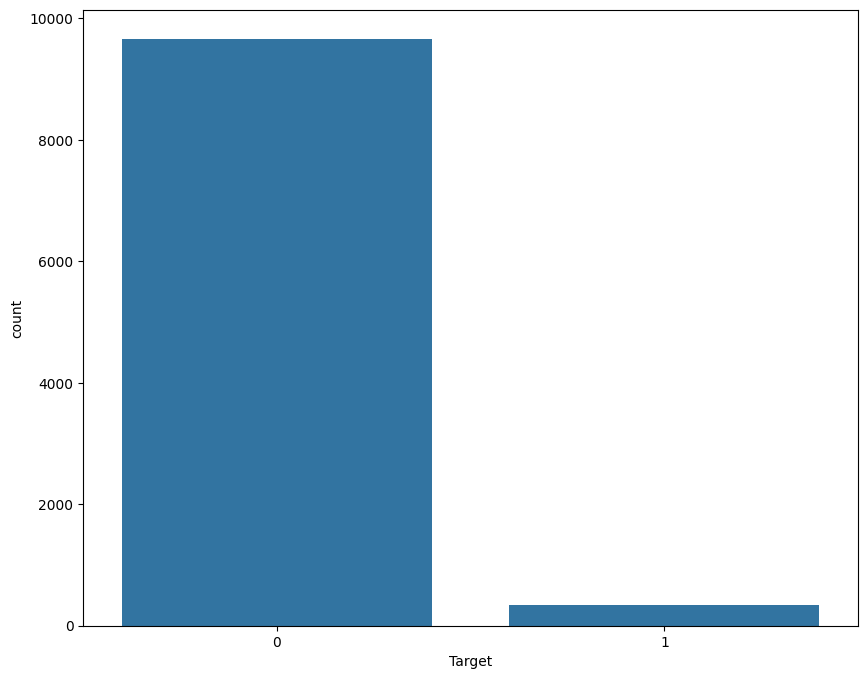

In [9]:
plt.figure(figsize=(10,8))
sns.countplot(data=df,x="Target")

**2\. Visualization of Errors by Type:**

By using the target variable, we can obtain the number of errors for each error type. This helps us understand which types of failures are most common and may indicate areas where improvements are needed. We can visualize this using a bar chart to easily compare the frequency of different error types.


<AxesSubplot: xlabel='Failure Type', ylabel='count'>

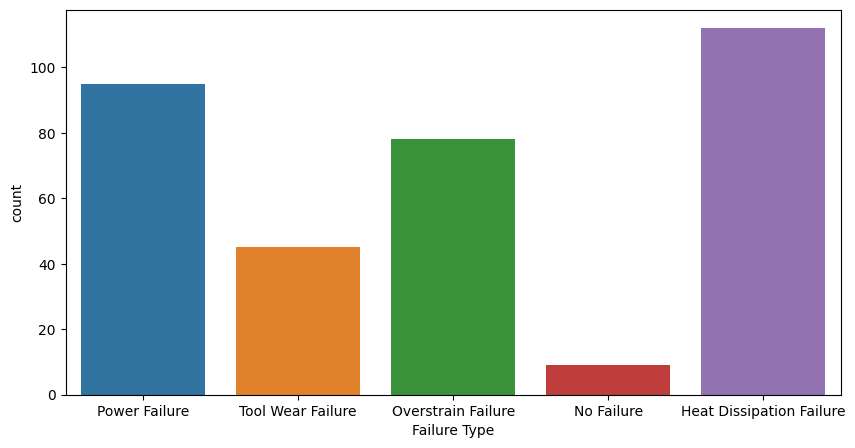

In [45]:
plt.figure(figsize=(10,5))
sns.countplot(data=df[df['Target']==1],x="Failure Type")



**1\. Distribution of Variables by Target Variable:**

To examine how other variables differ according to the target variable (e.g., Failure vs. No Failure), we can use pairplots. Pairplots provide a comprehensive view of the distribution and relationship of multiple variables. By coloring the plots according to the target variable, we can see how each feature behaves in failure and non-failure cases. This can help identify patterns or trends associated with machine faesults and improve the model.

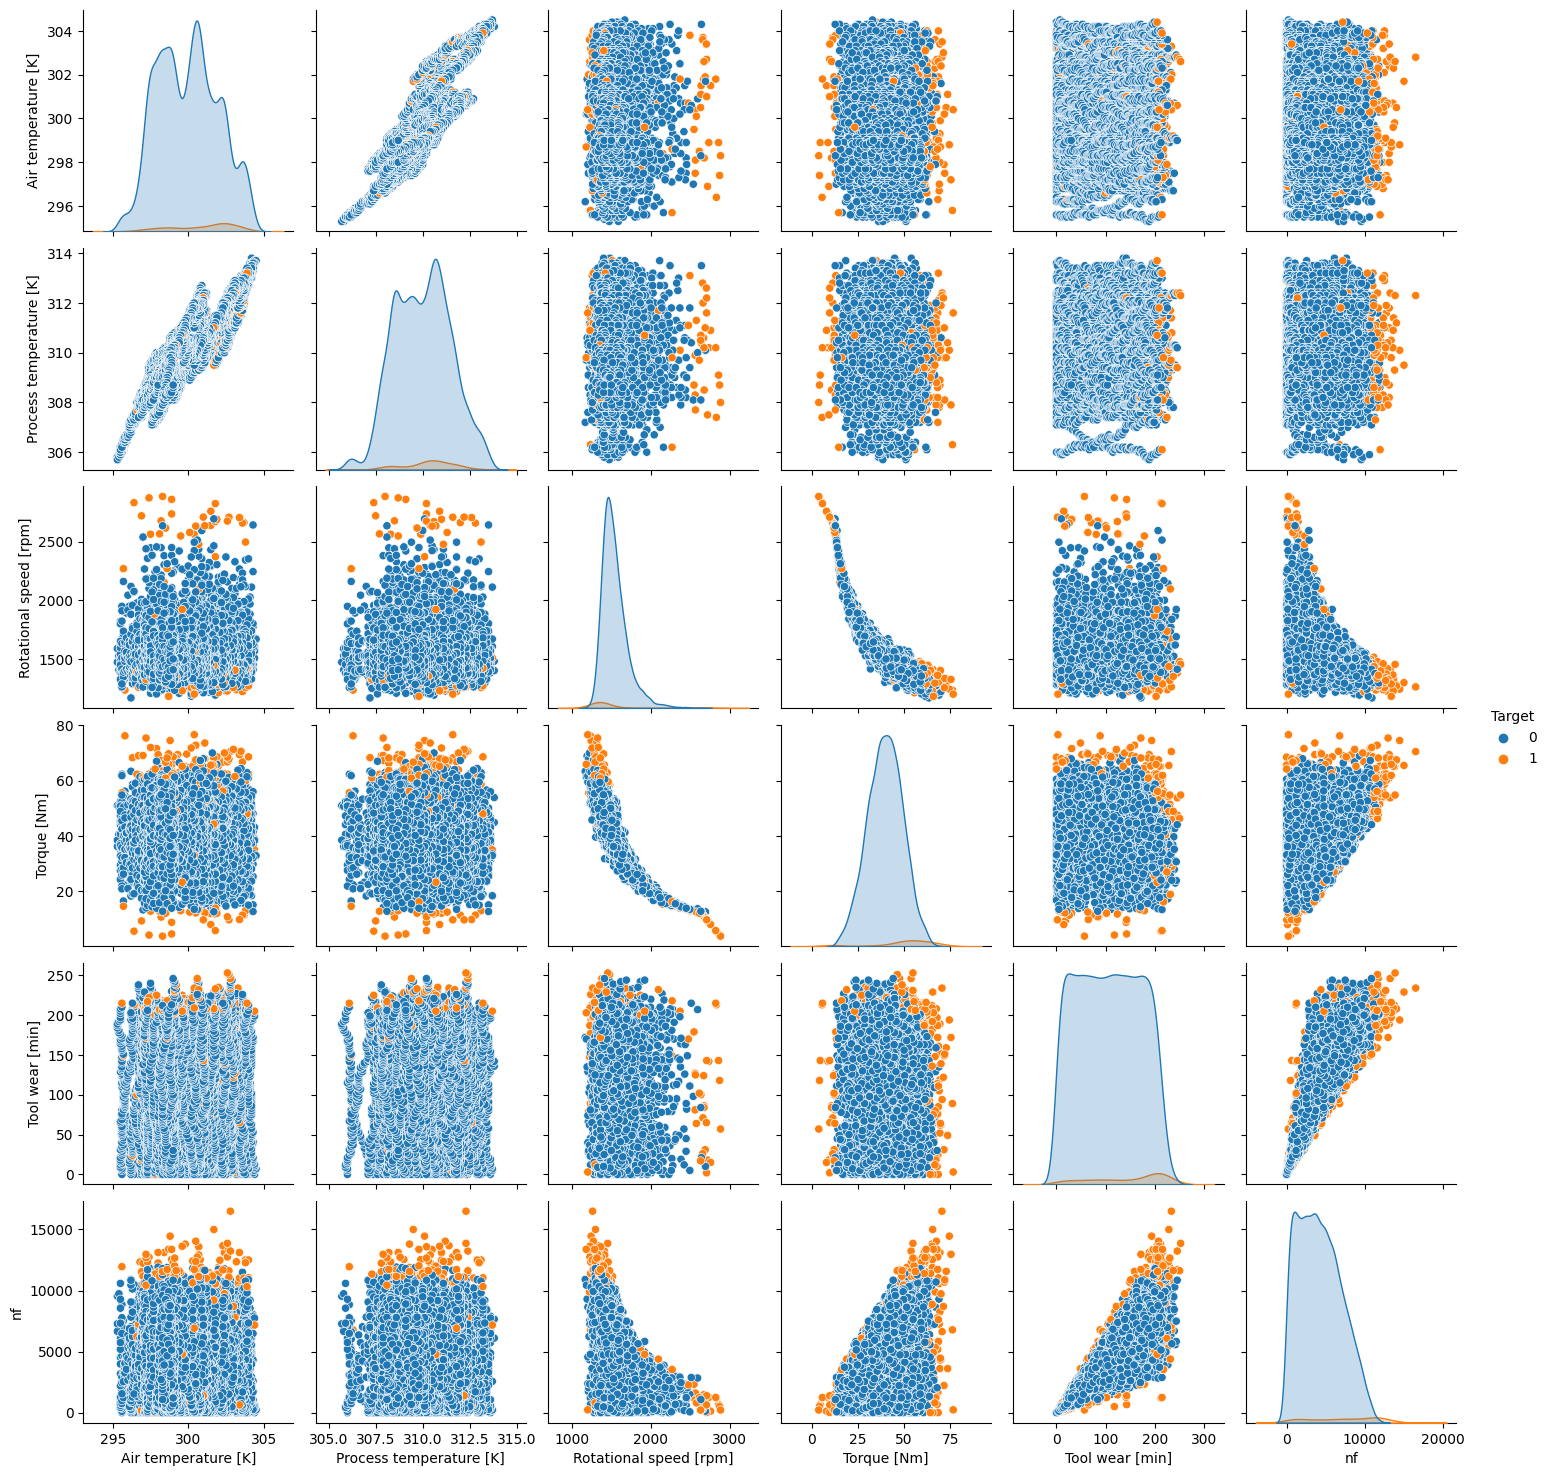

In [7]:
sns.pairplot(df,hue='Target')

**3\. Heat Map of Variable Correlations:**

A heat map is useful for visualizing the correlation between different variables in the dataset. By examining the heat map, we can see which variables are strongly or weakly correlated with each other. This information is crucial for understanding the interdependencies between features, which can influence model performance. Highly correlated variables may be redundant, while variables with low correlation to the target may have limited predictive power.



<AxesSubplot: >

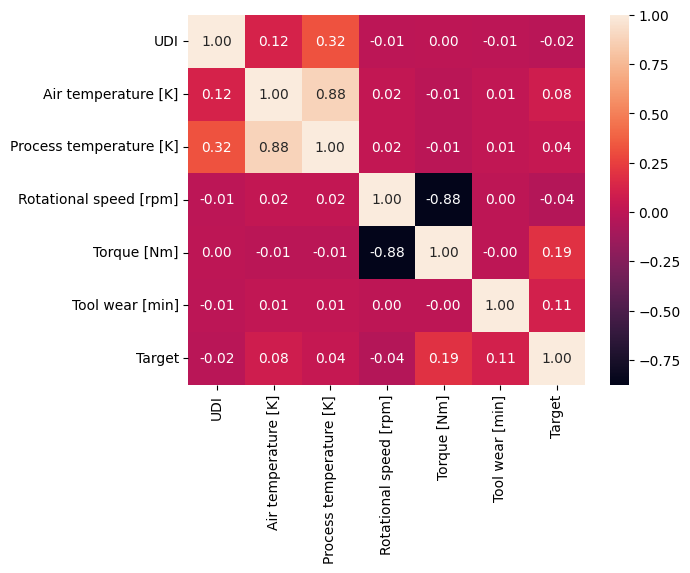

In [46]:
sns.heatmap(df.corr(), annot=True, fmt=".2f")

**4\. Boxplot of Numerical Variables by Target Variable:**

Boxplots allow us to visualize the variability and distribution of numerical variables according to the target variable. By plotting each numerical variable (e.g., air temperature, process temperature, rotational speed, torque, tool wear) against the target variable, we can see how these features differ in failure and non-failure cases. Boxplots highlight the median, quartiles, and potential outliers, providing a clear picture of the data distribution.



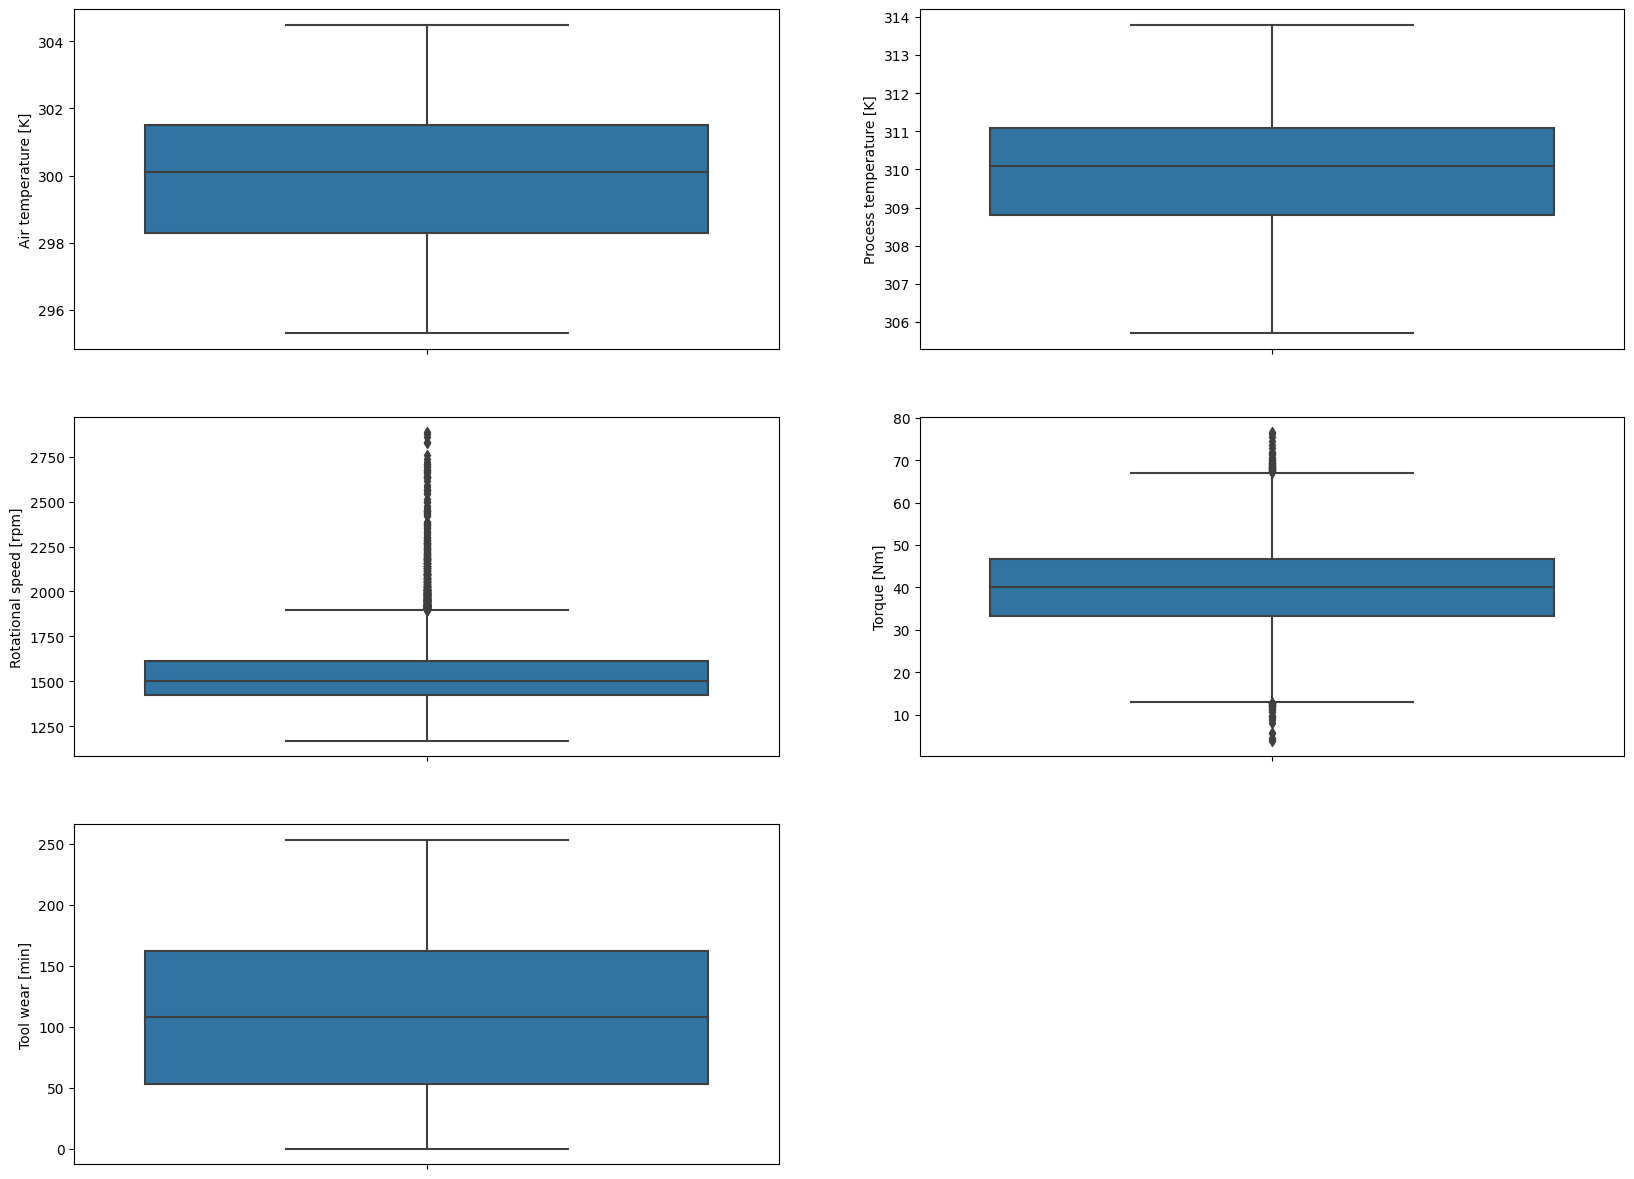

In [47]:
plt.figure(figsize = (20,15))
m=1
for i in ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'] :
    plt.subplot(3,2,m)
    sns.boxplot(data=df,y=i,hue="Target")
    m+=1

**5\. 3D Visualization of Key Variables:**

We can create a 3D plot to visualize the relationship between three key numerical variables, such as "Torque", "Rotational Speed", and "Tool Wear". This 3D visualization helps us see how these variables interact and vary together in different conditions (e.g., failure vs. no failure). This can be particularly useful for identifying complex patterns and interactions that may not be obvious in 2D plots.



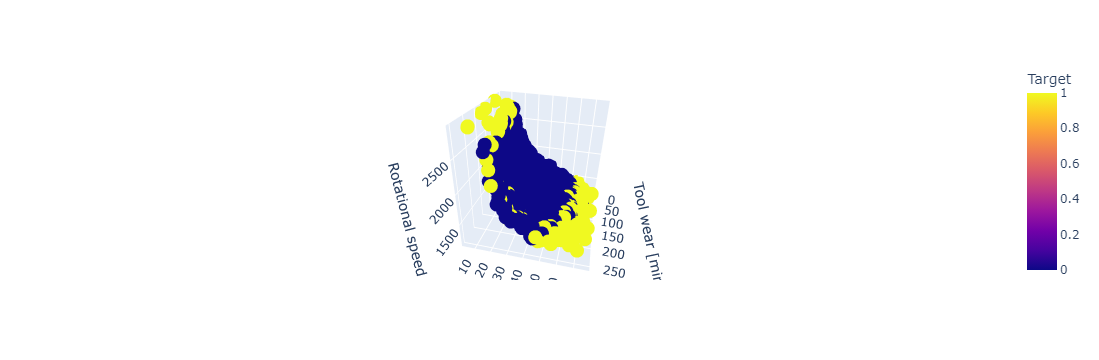

In [10]:
import plotly.express as px

fig = px.scatter_3d(df, x='Tool wear [min]', y='Torque [Nm]', z='Rotational speed [rpm]',
              color='Target')
fig.show()

**6\. Data Preprocessing:**

To prepare the dataset for machine learning, we need to preprocess the data. This includes encoding categorical variables into numeric form (e.g., converting the target variable and failure types into numeric labels). We also split the dataset into training and testing sets to evaluate model performance. Proper preprocessing ensures that the data is in the right format for machine learning algorithms and helps prevent data leakage.



In [10]:
df["Type"] = df["Type"].replace("L",0)
df["Type"] = df["Type"].replace("M",1)
df["Type"] = df["Type"].replace("H",2)

In [11]:
df_target = df.Target.copy()
df_failure_type = df["Failure Type"].copy()

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Failure Type','Target'],axis=1),
                                                    df['Target'], test_size=0.3, random_state=42)


**7\. Machine Learning Model Evaluation:**

After preprocessing the data, we import machine learning libraries and create a class to evaluate the accuracy of different algorithms. By testing multiple models (e.g., logistic regression, random forest, support vector machine), we can compare their performance and select the best one for our task. Evaluating models in a compact and systematic way makes it easier for data scientists to analyze results and improve the model.

In [14]:
import time

from sklearn.metrics import recall_score,classification_report, recall_score
classifier=[]
imported_as=[]

#LGBM
#import lightgbm as lgb
#lgbm = lgb.LGBMClassifier()
#classifier.append('LightGBM')
#imported_as.append('lgbm')

#MultiLayerPerceptron
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier()
classifier.append('Multi Layer Perceptron')
imported_as.append('mlp')

#Bagging
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
classifier.append('Bagging')
imported_as.append('bc')

#GBC
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
classifier.append('Gradient Boosting')
imported_as.append('gbc')

#ADA
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
classifier.append('Ada Boost')
imported_as.append('ada')

#XGB
#import xgboost as xgb
#from xgboost import XGBClassifier
#xgb = XGBClassifier() 
#classifier.append('XG Boost')
#imported_as.append('xgb')

In [15]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
classifier.append('Logistic Regression')
imported_as.append('lr')

#RFC
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
classifier.append('Random Forest')
imported_as.append('rfc')

#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
classifier.append('k Nearest Neighbours')
imported_as.append('knn')

#SVM
from sklearn.svm import SVC
svc = SVC()
classifier.append('Support Vector Machine')
imported_as.append('svc')

In [16]:
#Grid
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100, 1000,2000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
classifier.append('SVM tuning grid')
imported_as.append('grid')

#STcaking
from sklearn.ensemble import StackingClassifier
estimators=[('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
            ('svr',SVC(random_state=42))]
stc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
classifier.append('Stacked (RFR & SVM)')
imported_as.append('stc')

classifiers = pd.DataFrame({'Classifier':classifier,'Imported as':imported_as})
print('All Models Imported\nModels stored in dataframe called classifiers')

All Models Imported
Models stored in dataframe called classifiers


In [17]:
class Modelling:
    def __init__(self, X_train, Y_train, X_test, Y_test, models):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.models = models
    
    def fit(self):
        model_acc = []
        model_time= []
        for i in self.models:
            start=time.time()
            if i == 'knn':
                recall = []
                for j in range(1,200):    
                    kn = KNeighborsClassifier(n_neighbors=j)
                    kn.fit(self.X_train,self.Y_train)
                    predK = kn.predict(self.X_test)
                    recall.append([recall_score(self.Y_test,predK),j])
                temp = recall[0]
                for m in recall:
                    if temp[0] < m[0]:
                        temp=m
                i = KNeighborsClassifier(n_neighbors=temp[1])
            i.fit(self.X_train,self.Y_train)
            model_acc.append(recall_score(self.Y_test,i.predict(self.X_test)))
            stop=time.time()
            model_time.append((stop-start))
            print(i,'has been fit')
        self.models_output = pd.DataFrame({'Models':self.models,'recall':model_acc,'Runtime (s)':model_time})
        
    def results(self):
        models=self.models_output
        models = models.sort_values(by=['recall','Runtime (s)'],ascending=[False,True]).reset_index().drop('index',axis=1)
        self.best = models['Models'][0]
        models['Models']=models['Models'].astype(str).str.split("(", n = 2, expand = True)[0]
        models['recall']=models['recall'].round(5)*100
        self.models_output_cleaned=models
        return(models)
        
    def best_model(self,type):
        if type=='model':
            return(self.best)
        elif type=='name':
            return(self.models_output_cleaned['Models'][0])
    
    def best_model_recall(self):
        return(self.models_output_cleaned['recall'][0])
    
    def best_model_runtime(self):
        return(round(self.models_output_cleaned['Runtime (s)'][0],3))
    
    def best_model_predict(self,X_test):
        return(self.best.predict(X_test))
    
    def best_model_clmatrix(self):
        return(classification_report(self.Y_test,self.best.predict(self.X_test)))

In [18]:
models_to_test = [bc,gbc,ada,rfc,mlp,lr,knn,stc]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 9069 to 7270
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     7000 non-null   int64  
 1   Air temperature [K]      7000 non-null   float64
 2   Process temperature [K]  7000 non-null   float64
 3   Rotational speed [rpm]   7000 non-null   int64  
 4   Torque [Nm]              7000 non-null   float64
 5   Tool wear [min]          7000 non-null   int64  
 6   nf                       7000 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 437.5 KB


In [19]:
classification=Modelling(X_train,y_train,X_test,y_test,models_to_test)
classification.fit()

BaggingClassifier() has been fit
GradientBoostingClassifier() has been fit
AdaBoostClassifier() has been fit
RandomForestClassifier() has been fit
MLPClassifier() has been fit
LogisticRegression() has been fit
KNeighborsClassifier(n_neighbors=1) has been fit
StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr', SVC(random_state=42))],
                   final_estimator=LogisticRegression()) has been fit


In [20]:
classification.results()

Models  recall  Runtime (s)
0           BaggingClassifier  77.419     0.390558
1  GradientBoostingClassifier  70.968     1.831704
2      RandomForestClassifier  69.892     1.327072
3          StackingClassifier  62.366     2.478635
4          AdaBoostClassifier  44.086     0.510558
5               MLPClassifier  43.011     0.464568
6        KNeighborsClassifier  41.935     0.217487
7          LogisticRegression  29.032     0.081242

In [21]:
print(classification.best_model_clmatrix())

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2907
           1       0.87      0.77      0.82        93

    accuracy                           0.99      3000
   macro avg       0.93      0.89      0.91      3000
weighted avg       0.99      0.99      0.99      3000



In [22]:
bc

BaggingClassifier()

In [57]:
X_test

Type  Air temperature [K]  Process temperature [K]  \
6252     0                300.8                    310.3   
4684     1                303.6                    311.8   
1731     1                298.3                    307.9   
4742     0                303.3                    311.3   
4521     0                302.4                    310.4   
...    ...                  ...                      ...   
8014     0                300.9                    312.0   
1074     0                297.0                    307.9   
3063     0                300.0                    309.1   
6487     2                300.6                    309.8   
4705     0                303.6                    311.8   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]      nf  
6252                    1538         36.1              198  7147.8  
4684                    1421         44.8              101  4524.8  
1731                    1485         42.0              117  4914.0  
4742                    1592         33.7               14   471.8  
4521                    1865         23.9              129  3083.1  
...                      ...          ...              ...     ...  
8014                    1500         44.2              188  8309.6  
1074                    1595         31.7              170  5389.0  
3063                    1431         45.4               90  4086.0  
6487                    1541         36.2              166  6009.2  
4705                    1614         33.2              155  5146.0  

[3000 rows x 7 columns]

In [72]:
bc

BaggingClassifier()

In [24]:
import joblib

joblib.dump(bc, 'model.pkl')

['model.pkl']

In [25]:
bc.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
X_test

Type  Air temperature [K]  Process temperature [K]  \
6252     0                300.8                    310.3   
4684     1                303.6                    311.8   
1731     1                298.3                    307.9   
4742     0                303.3                    311.3   
4521     0                302.4                    310.4   
...    ...                  ...                      ...   
8014     0                300.9                    312.0   
1074     0                297.0                    307.9   
3063     0                300.0                    309.1   
6487     2                300.6                    309.8   
4705     0                303.6                    311.8   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]      nf  
6252                    1538         36.1              198  7147.8  
4684                    1421         44.8              101  4524.8  
1731                    1485         42.0              117  4914.0  
4742                    1592         33.7               14   471.8  
4521                    1865         23.9              129  3083.1  
...                      ...          ...              ...     ...  
8014                    1500         44.2              188  8309.6  
1074                    1595         31.7              170  5389.0  
3063                    1431         45.4               90  4086.0  
6487                    1541         36.2              166  6009.2  
4705                    1614         33.2              155  5146.0  

[3000 rows x 7 columns]

In [77]:
pd.get_dummies(df, columns=['Failure Type'], drop_first=True)

Type  Air temperature [K]  Process temperature [K]  \
0        1                298.1                    308.6   
1        0                298.2                    308.7   
2        0                298.1                    308.5   
3        0                298.2                    308.6   
4        0                298.2                    308.7   
...    ...                  ...                      ...   
9995     1                298.8                    308.4   
9996     2                298.9                    308.4   
9997     1                299.0                    308.6   
9998     2                299.0                    308.7   
9999     1                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target      nf  \
0                       1551         42.8                0       0     0.0   
1                       1408         46.3                3       0   138.9   
2                       1498         49.4                5       0   247.0   
3                       1433         39.5                7       0   276.5   
4                       1408         40.0                9       0   360.0   
...                      ...          ...              ...     ...     ...   
9995                    1604         29.5               14       0   413.0   
9996                    1632         31.8               17       0   540.6   
9997                    1645         33.4               22       0   734.8   
9998                    1408         48.5               25       0  1212.5   
9999                    1500         40.2               30       0  1206.0   

      Failure Type_No Failure  Failure Type_Overstrain Failure  \
0                           1                                0   
1                           1                                0   
2                           1                                0   
3                           1                                0   
4                           1                                0   
...                       ...                              ...   
9995                        1                                0   
9996                        1                                0   
9997                        1                                0   
9998                        1                                0   
9999                        1                                0   

      Failure Type_Power Failure  Failure Type_Random Failures  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   
...                          ...                           ...   
9995                           0                             0   
9996                           0                             0   
9997                           0                             0   
9998                           0                             0   
9999                           0                             0   

      Failure Type_Tool Wear Failure  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  
...                              ...  
9995                               0  
9996                               0  
9997                               0  
9998                               0  
9999                               0  

[10000 rows x 13 columns]